In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import pathlib

python_path = pathlib.Path('.').absolute().parent/'python'
os.sys.path.insert(1, str(python_path))

In [3]:
## This is demo for kuka reaching a desired point with diff_qp
## Author : Avadesh Meduri
## Date : 25/02/2022
import time
import numpy as np
import pinocchio as pin
from robot_properties_kuka.config import IiwaConfig

import meshcat
import meshcat.transformations as tf
import meshcat.geometry as g

from vocam.diff_pin_costs import DiffFrameTranslationCost, DiffFrameVelocityCost
from vocam.inverse_qp import IOC

import torch
from torch.autograd import Function
from torch.nn import functional as F

In [4]:
robot = IiwaConfig.buildRobotWrapper()
model, data = robot.model, robot.data
f_id = model.getFrameId("EE")

In [5]:
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [6]:
dtc = DiffFrameTranslationCost.apply
dvc = DiffFrameVelocityCost.apply

def quadratic_loss(q_pred, x_des, nq, n_col):
    loss = 4.0e1*torch.linalg.norm(dtc(q_pred[-2*nq:], model, data, f_id) - x_des)
    loss += 2.5e0*torch.linalg.norm(dvc(q_pred[-2*nq:], torch.zeros(nq), model, data, f_id)) # asking for zero velocity
    loss += 1e-2*torch.linalg.norm(q_pred[-2*nq:-nq]) # joint regularization
    
    for i in range(n_col):    
        loss += 1e0*torch.linalg.norm(dtc(q_pred[(3*i)*nq: (3*i+2)*nq], model, data, f_id) - x_des)
        loss += 5e-1*torch.linalg.norm(dvc(q_pred[(3*i)*nq: (3*i+2)*nq], q_pred[(3*i+2)*nq:(3*i+3)*nq], model, data, f_id)) # asking for zero velocity
        loss += 1e-2*torch.linalg.norm(q_pred[(3*i+2)*nq: (3*i+3)*nq]) # control regularization
        loss += 2e-1*torch.linalg.norm(q_pred[(3*i+1)*nq: (3*i+2)*nq]) # velocity regularization
        loss += 3e-3*torch.linalg.norm(q_pred[(3*i)*nq: (3*i+1)*nq]) # joint regularization
        loss += 2e-3*torch.linalg.norm(q_pred[(3*i)*nq+3: (3*i+1)*nq])
        loss += 4e-3*torch.linalg.norm(q_pred[(3*i)*nq+5])
        
        if i < n_col - 1:
            loss += 5e-2*torch.linalg.norm(torch.subtract(q_pred[(3*i+2)*nq: (3*i+3)*nq], \
                                                          q_pred[(3*i+5)*nq: (3*i+6)*nq]))

    return loss

In [7]:
nq = model.nq
nv = model.nv
q0 = [np.pi/16.0, -np.pi/16.0, 0, 0, 0, 0, 0]
x_init = np.concatenate([q0, pin.utils.zero(model.nv)])

n_col = 5
u_max = [2.5,2.5,2.5, 1.5, 1.5, 1.5, 1.0]
dt = 0.05

isvec = True
lr = 1e-1
max_eps = 100



In [11]:
buffer_size = 10000
f_name = "5"
n_mpc = 25
d_tol = 0.05 # how close the ee should be to the ball to be accepted as a good data point

x_train = torch.zeros((1,len(x_init) + 3))
x_train_tmp = torch.zeros((n_mpc,len(x_init) + 3))

n_vars = 3*nq*n_col + 2*nq
if not isvec:
    y_train_tmp = torch.zeros((n_mpc, n_vars**2 + n_vars))
else:
    y_train_tmp = torch.zeros((n_mpc, 2*n_vars))

q_des_arr = np.array([[2.1789238e-02,  3.3214998e-01, -1.4518893e-04, -8.7141126e-01,
                          6.0329604e-01, -1.3965217e-03,  1.4794523e-04],
                      [1.3737, 0.9711, 1.6139, 1.2188, 1.5669, 0.1236, 0.2565]])
# x_des_arr = torch.tensor([[0.5, -0.4, 0.7], [0.6, 0.4, 0.5]])
x_des_arr = torch.tensor([[0.3, -0.3, 0.7], [0.6, 0.2, 0.5]])



In [12]:
for k in range(buffer_size):

#     print(k % n_mpc)
    if k % n_mpc == 0:
        
        ## Adding to data only if the kuka reaches the ball
        if k > 0:
            dist = torch.linalg.norm(dtc(x_pred[-2*nq:], model, data, f_id) - x_des)
            if dist <= d_tol:
                if len(x_train) != 1:
                    x_train = torch.vstack((x_train, x_train_tmp))
                    y_train = torch.vstack((y_train, y_train_tmp))                
                elif len(x_train) == 1:
                    x_train = x_train_tmp
                    y_train = y_train_tmp
                    
                    x_train_tmp = torch.zeros_like(x_train_tmp)
                    y_train_tmp = torch.zeros_like(y_train_tmp)
                
        r = 0.4*np.random.rand(1) +0.5
        theta = 2*0.5*np.pi*(np.random.rand(1))
        x_des = torch.squeeze(torch.tensor([r*np.sin(theta), r*np.cos(theta), 0.6*np.random.rand(1)+0.2]))
#         x_des = x_des_arr[1]

        viz.viewer["box"].set_object(g.Sphere(0.05), 
                         g.MeshLambertMaterial(
                             color=0xff22dd,
                             reflectivity=0.8))
        viz.viewer["box"].set_transform(tf.translation_matrix(x_des.detach().numpy()))
        
        if np.random.randint(2) != 0 or k == 0:
            x_init = np.zeros(2*nq)
            x_init[0:nq] = q_des_arr[0] + 0.3*2*(np.random.rand(nq) - 0.5)
            x_init[0] -= 2*0.5*(np.random.rand(1) - 0.5)
            x_init[2] -= 2*0.3*(np.random.rand(1) - 0.5)
            x_init[nq:] = 0.4*2*(np.random.rand(nv) - 0.5)
    
    else:
        x_init = x_pred_np[3*nq*(n_col-1):3*nq*(n_col-1) + 2*nq]
    
    i = 0
    loss = 1000.
    old_loss = 10000.

    ioc = IOC(n_col, nq, u_max, dt, eps = 1.0, isvec=isvec)
    optimizer = torch.optim.Adam(ioc.parameters(), lr=lr)
    
    while loss > 0.03 and i < max_eps and abs(old_loss - loss) > 5e-4:
        x_pred = ioc(x_init) 
        old_loss = loss
        loss = quadratic_loss(x_pred, x_des, nq, n_col)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1

    print("Index :" + str(k) + "/" + str(buffer_size) + " Data Size is : " + str(len(x_train))\
          + " loss is : " + str(np.round(loss.detach().numpy(),3)), end = '\r', flush = True)
    x_pred_np = ioc(x_init).detach().numpy()
    
    for i in range(n_col+1):
        q = x_pred_np[3*nq*i:3*nq*i + nq]
        dq = x_pred_np[3*nq*i + nq:3*nq*i + 2*nq]

        pin.forwardKinematics(model, data, q, dq, np.zeros(nv))
        pin.updateFramePlacements(model, data)

        viz.display(q)
        time.sleep(0.01)
    
    # storing x train
    x_train_tmp[k % n_mpc][0:2*nq] = torch.tensor(x_init)
    x_train_tmp[k % n_mpc][2*nq:] = x_des
    
    # storing the weights and x_nom
    y_train_tmp[k % n_mpc] = torch.hstack((ioc.weight.flatten(), ioc.x_nom))

    if k % 100 == 0 and k:
        torch.save(x_train[0:k], "../data/x_train" + str(f_name) + ".pt")
        torch.save(y_train[0:k], "../data/y_train" + str(f_name) + ".pt")

torch.save(x_train, "../data/x_train" + str(f_name) + ".pt")
torch.save(y_train, "../data/y_train" + str(f_name) + ".pt")

/tmp/ipykernel_1246852/1511279488.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  x_des = torch.squeeze(torch.tensor([r*np.sin(theta), r*np.cos(theta), 0.6*np.random.rand(1)+0.2]))


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

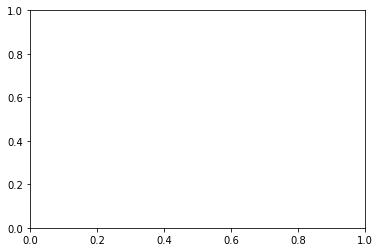

In [10]:
from matplotlib import pyplot as plt

plt.plot(x_pred[2*nq + 1:: 3*nq], label = "joint torque")
plt.legend()
plt.grid()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,0], label = "x_pos")
plt.grid()
plt.legend()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,1], label = "y_pos")
plt.grid()
plt.legend()

In [ ]:
plt_des = np.array(plt_des)
plt.plot(plt_des[:,2], label = "z_pos")
plt.grid()
plt.legend()

In [ ]:
from mim_data_utils import DataLogger, DataReader
reader = DataReader('test.mds')

for i in range(len(reader.data['joint_positions'])):
    q = reader.data['joint_positions'][i]
    viz.display(q)
#     time.sleep(0.05)

In [ ]:
x_train[0]

In [ ]:
a = np.array([10,20,30,40])
b = np.array([5,4,3,2])
a*b